# CSAF System Simulation

## Overview

This notebook illustrates how to take a system configuration TOML file and generate pub/sub components that can be used for simulation of controlled systems. By default, it exposes all examples in the `examples/` directory, but custom toml files can be passed by changing the `config_filename` variable.

In [1]:
# notebook for animations
%matplotlib notebook
%matplotlib inline

# CSAF imports
# add csaf to path via sys module, and then import the submodules with config and system objects
import sys
sys.path.append("../../src/")
sys.path.append("../../src/scripts")

import csaf.config as cconf
import csaf.system as csys

In [2]:
# IPython display and formatting imports
from IPython.display import display, Markdown, Image

# numerical processing and plotting utilities 
import numpy as np
import matplotlib.pyplot as plt

## Example Selection and Notebook Configuration

In [3]:
## list the example names that the user is allowed to run under the `example_name` variable
import pathlib

def grab_configurations():
    """populate a dictionary of example names and paths to their respective toml configuration files"""
    example_dir = pathlib.Path("../../examples/").resolve()
    return {" ".join(path.stem.split("_")[:-1]):str(path) for path in example_dir.rglob('*config.toml')}

example_configs = grab_configurations()

# pretty print to markdown
display(Markdown("### Examples"))
display(Markdown("* " + "\n* ".join(example_configs.keys())))

### Examples

* f16 shield
* f16 simple
* inv pendulum

In [4]:
# change to a valid filepath to use a custom system
config_filename = None

# name of example to run (see list above for the correct name)
example_name = "f16 simple"

# name of pub/sub diagram to save (change extension if necessary)
plot_fname = f"pub-sub-plot.png"

# timespan to simulate over (in seconds)
simulation_timespan = [0, 35.0]

## CSAF Configuration

A complete system description, including a description of the individual components, is spread over many files that need to be loaded by the CSAF package. The `SystemConfig` class is responsible for storing these descriptions into a comprehensive data structure, as well as checking that certain description properties hold. The `.plot_config` method provides a method to view the configuration as a pub/sub diagram.

In [5]:
# ensure that the example name is valid
assert example_name in example_configs, f"{example_name} not found in valid configs {list(example_configs.keys())}"

# create a csaf configuration out of toml
my_conf = cconf.SystemConfig.from_toml(config_filename \
                                       if config_filename is not None \
                                       else example_configs[example_name])

02:49:38 PM: (INFO)  setting up CSAF System from TOML file '/home/mpodhradsky/Workspace/CPS/csaf_architecture/examples/f16/f16_simple_config.toml'
02:49:38 PM: (INFO)  Output Dir: /home/mpodhradsky/Workspace/CPS/csaf_architecture/examples/f16/output
02:49:38 PM: (INFO)  Codec Dir: /home/mpodhradsky/Workspace/CPS/csaf_architecture/examples/f16/codec
02:49:38 PM: (INFO)  Log Level: info
WARNING! log will output to file that already exists: '/home/mpodhradsky/Workspace/CPS/csaf_architecture/examples/f16/output/f16run.log'


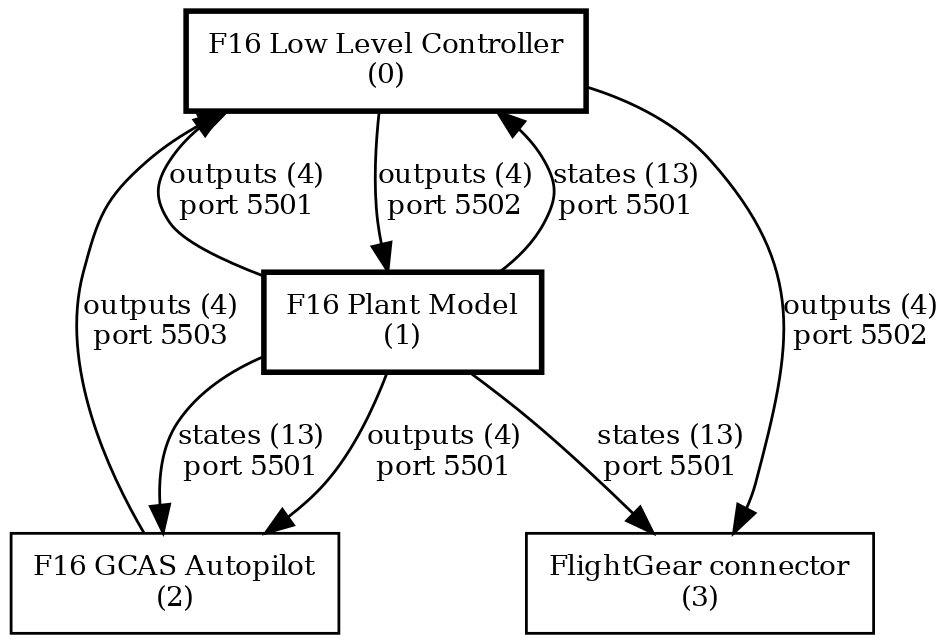

In [6]:
# plot configuration pub/sub diagram as a file -- proj specicies a dot executbale and -Gdpi is a valid dot
# argument to change the image resolution
my_conf.plot_config(fname=pathlib.Path(plot_fname).resolve(), prog=["dot", "-Gdpi=200"])

# display written file to notebook
Image(plot_fname, height=600)

## CSAF System

Once the CSAF coniguration loads the needed data, the `System` class loads the CSAF components, creating ones where necessary. `.simulate_tspan` supports simulating this system across fixed timespans.

In [7]:
# now, create pub/sub components out of the configuration
# these components will be bound to ports, which will fail if the ports are used elsewhere
my_system = csys.System.from_config(my_conf)

In [8]:
# simulate and collect time traces out of the components
trajs = my_system.simulate_tspan(simulation_timespan, show_status=True)

100%|██████████| 7700/7700 [00:10<00:00, 741.10it/s]


In [9]:
# destroy components and unbind all used sockets
# this system can no longer run, and another can be created 
my_system.unbind()

In [10]:
# pretty print the components and their named fields from simulation output
display(Markdown("### Simulation Traces\n" + \
                 "\n".join(
                    [f"* {cname}\n"+ \
                     "\n".join([f"    * {tname}" for tname in ctrace.names]) for cname, ctrace in trajs.items()])
                )
       )

### Simulation Traces
* controller
    * times
    * outputs
    * states
* plant
    * times
    * outputs
    * states
* autopilot
    * times
    * states
    * outputs
    * fdas
* flightgear
    * times

## Plotting the Example

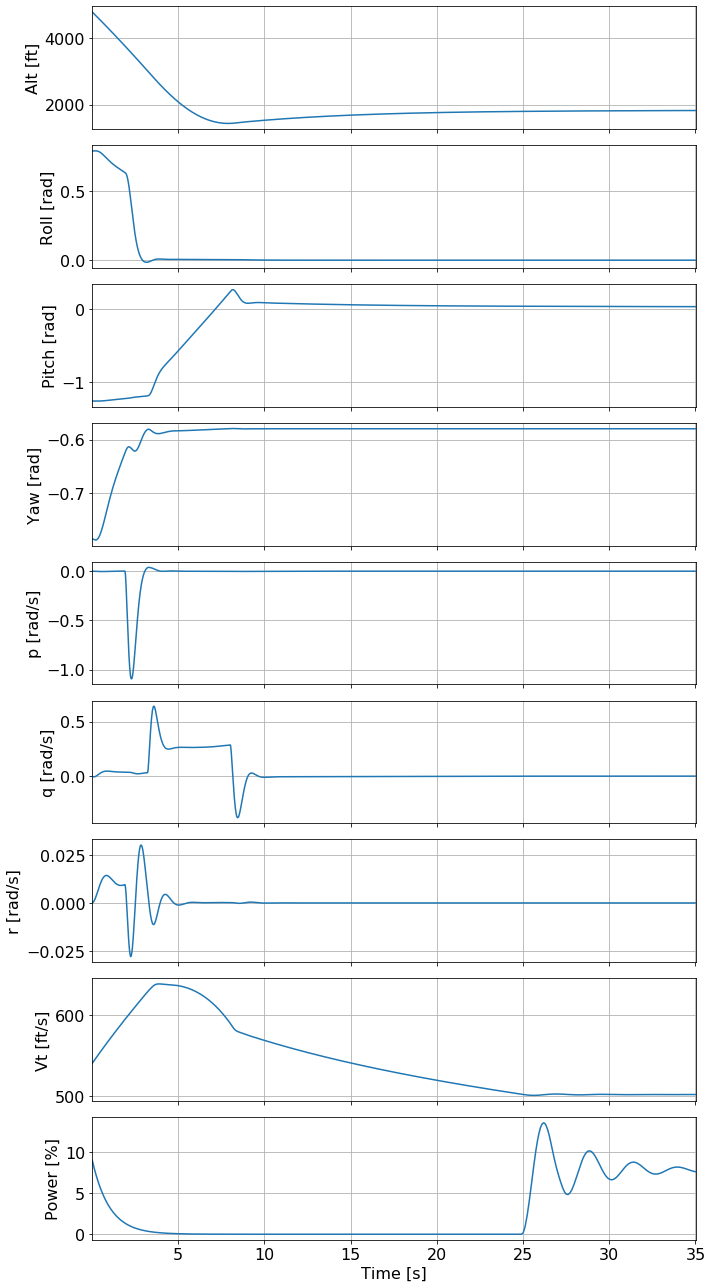

In [11]:
## 2D Plotting Multiple for F16 Model
if "f16" in example_name:
    from plot import plot2d_multiple_simple
    import enum
    states = ['vt', 'alpha', 'beta', 'phi', 'theta', 'psi', 'p', 'q', 'r', 'pn', 'pe', 'h', 'power']
    State = enum.IntEnum('State', states, start=0)
    plot2d_multiple_simple([trajs["plant"]],
                        [('states',
                            [(State.h, 'Alt [ft]'),
                             (State.phi, 'Roll [rad]'),
                             (State.theta, 'Pitch [rad]'),
                             (State.psi, 'Yaw [rad]'),
                             (State.p, 'p [rad/s]'),
                             (State.q, 'q [rad/s]'),
                             (State.r, 'r [rad/s]'),
                             (State.vt, 'Vt [ft/s]'),
                             (State.power, 'Power [%]')])], fullscreen=False)

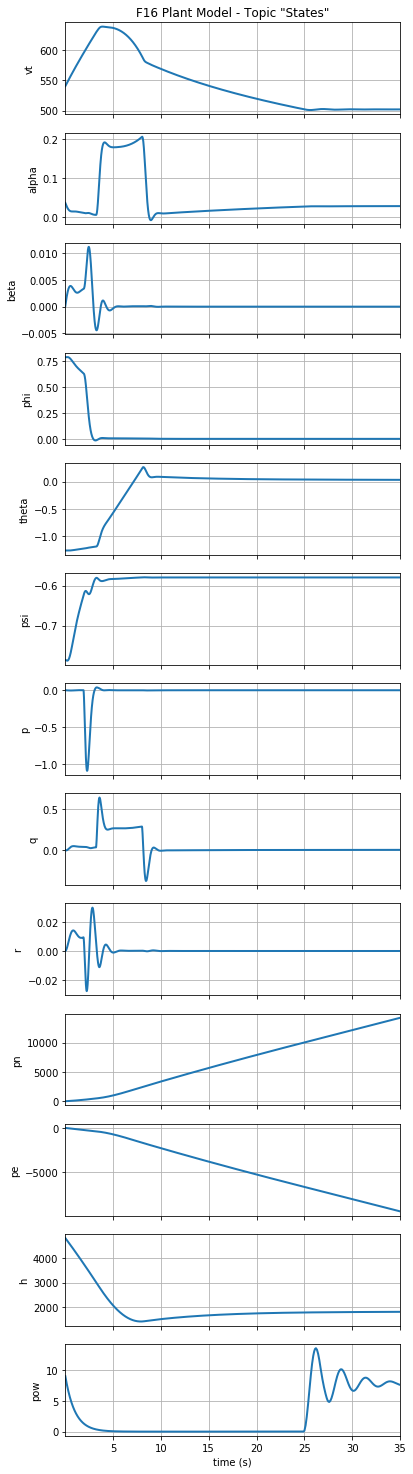

In [12]:
## Generic Plotting

# select component to plot
component_name = "plant"

# select topic of component to plot
topic_name = "states"


if component_name in trajs:
    # time trace of component
    ttrace = trajs[component_name]
    
    if not hasattr(ttrace, topic_name):
        raise RuntimeError(f"ERROR! Invalid topic name {topic_name} for component {component_name}")
    
    # collect time and data to plot
    t, data = ttrace.times, np.array(getattr(ttrace, topic_name))
    
    # number of dimensions -> number of plots
    n_dim = data.shape[1]
    
    # get full component name
    component_vname = my_conf.get_component_settings(component_name)["config"]["system_name"]
    
    # get names of topic from ROSmsg -- skip boilerplate
    names = my_conf.get_msg_setting(component_name, topic_name, "msg").fields_no_header
    
    # create matplotlib axes and plot
    fig, axs = plt.subplots(figsize=(12/2, n_dim*4/2),nrows=n_dim, sharex=True)
    for idx, ax in enumerate(axs):
        # plot formatting
        ax.plot(t, data[:, idx], LineWidth=2)
        ax.set_ylabel(names[idx])
        ax.set_xlim(min(t), max(t))
        ax.grid()
        
    # set figure title
    axs[0].set_title(f"{component_vname} - Topic \"{topic_name.title()}\"")
    
    # on last axis, set the time label
    axs[-1].set_xlabel("time (s)")
else:
    raise RuntimeError(f"ERROR! Invalid component name {component_name}")